In [1]:
import django, sys, os
sys.path.append('/home/max/software/django-tmv/tmv_mcc-apsis/BasicBrowser')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from sklearn.decomposition import NMF
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier

from scoping.models import *
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from itertools import product, combinations
from utils.text import *
from scipy.sparse import find

import math
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

from MulticoreTSNE import MulticoreTSNE as mTSNE
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import coverage_error, label_ranking_average_precision_score, label_ranking_loss
from pycountry_convert import  country_alpha2_to_continent_code, country_alpha3_to_country_alpha2
import pickle
import scipy.sparse
import datetime


In [2]:
def cross_validate_models(X,y,clf_models, seen_index, n_splits=10, classes=None):

    kf = KFold(n_splits=10)
    i=0
    

    for model in clf_models:
        model['p'] = []
        model['r'] = []
        model['e'] = []
        model['i'] = []
        metrics = ['e']        
        if classes:
            model['cov_err'] = []
            model['LRAP'] = []
            model['LRL'] = []
            for j, y_class in enumerate(classes):
                model[f'p\n{y_class}'] = []
                model[f'r\n{y_class}'] = []
                metrics += [f'p\n{y_class}', f'r\n{y_class}']


    for k_train, k_test in kf.split(seen_index):
        k_train = seen_index[k_train]
        k_test = seen_index[k_test]
        i+=1
        print(i)
        for model in clf_models:
            clf = model['model']
            model['i'].append(i)
            #clf = SVC(kernel='rbf',probability=True)
            clf.fit(X[k_train],y[k_train])
            predictions = clf.predict(X[k_test])
            model['e'].append(clf.score(X[k_test],y[k_test]))
            if classes:
                model['cov_err'].append(coverage_error(predictions, y[k_test,:]))
                model['LRAP'].append(label_ranking_average_precision_score(predictions, y[k_test,:]))
                model['LRL'].append(label_ranking_loss(predictions, y[k_test,:]))
                for j, y_class in enumerate(classes):
                    model[f'p\n{y_class}'].append(precision_score(predictions[:,j],y[k_test,j]))
                    model[f'r\n{y_class}'].append(recall_score(predictions[:,j],y[k_test,j]))
            else:
                # Precision
                model['p'].append(precision_score(predictions,y[k_test]))
                # Recall
                model['r'].append(recall_score(predictions,y[k_test]))
            
    if classes:
        return clf_models, metrics
    else:
        return clf_models

def plot_model_output(models, metrics, fig, axs):
    
    for i, model in enumerate(models):
        ax = axs[i]
        ax.boxplot([model[x] for x in metrics])

        for i,s in enumerate(metrics):
            ys = model[s]
            x = np.random.normal(i+1, 0.04, size=len(ys))
            ax.plot(x, ys, 'r.', alpha=0.2)

        ax.set_xticklabels([x for x in metrics], rotation=45, ha="right")

        ax.set_title(f'{model["title"]} mean accuracy {np.mean(model["e"]):.0%}')
        ax.grid()

    fig.tight_layout()
                     
m_metrics = ['e','cov_err', 'LRAP','LRL']
plt.rcParams['grid.linestyle'] = "--"

In [3]:
pid = 178
qid = 7368
q = Query.objects.get(pk=qid)
p = Project.objects.get(pk=pid)

print(q.doc_set.count())

318385


### Collect the AR5 docs

In [4]:
ar5_docs = Doc.objects.filter(query=6956, content__iregex="\w").exclude(
    pk__in=[
        1461495, # Espinoza 2013
        1626875, # White, 2007
        1622783, # Why is Oliveira, 2007 included?
        1627593, # Killeen 2008
        1627701, # Also, Nepstad and Stickler, 2008
        2093363, # Etter
        2090005, # Nepstad, 2006
        1627734, # Polidoro 2010
        2089982, # Mars, 2007
        2090013, # Randolph 2010
        2093360, # Petney 2012
        2089960, # Wassenaar, 2007 - LUC
        1627733, # Polidoro 2010, very weak - not main conclusion
        2090004, # Veran 2007 - long line fishing
        2089967, # Giri - mangrove database, climate only mentioned in conclusion and with reference
        2089944, # Jellyman - eels
        2091676, # Novelo-Casanova, 2010: Cayman Islands climate??
        2089959, # Bruno, 2007 
        1514856, # de Waroux 2012
        2091680, # Guzman, 2008, we consider the main anthropogenic threats to the coral reefs and communities of the islands are overfishing, sedimentation and tourism
        2089950
    ]
)

ar5_ids = set(ar5_docs.values_list('pk',flat=True))

ar5_docs.count()

257

### Collect the rated documents and merge with the ar5s

In [50]:
seen = set(DocOwnership.objects.filter(
    query=q, 
    relevant__gt=0
).values_list('doc__pk', flat=True))

print("seen docs",len(seen))

all_seen_ids = seen | ar5_ids
seen_docs = Doc.objects.filter(pk__in=all_seen_ids)
seen_docs.count()

seen docs 718


975

### Collect all the other unrated documents

In [6]:
unseen_docs = q.doc_set.filter(content__iregex='\w').exclude(pk__in=all_seen_ids).distinct('id')

columns = [
    'id',
    'content',
    'title',
    'wosarticle__de',
    'wosarticle__wc'
]

unseen_df = pd.DataFrame.from_dict(list(unseen_docs.values(*columns)))
unseen_df = unseen_df[columns]
unseen_df['relevant'] = 0
unseen_df['seen'] = 0

print(unseen_df.shape)
unseen_df.head()

(316475, 7)


,id,content,title,wosarticle__de,wosarticle__wc,relevant,seen
0,20,The responsiveness of South African fauna to c...,Vulnerability of South African animal taxa to ...,conservation; fragmentation; land-use; range c...,[Biodiversity Conservation; Ecology; Environme...,0,0
1,26,Physical and chemical limnological variables w...,Physical and chemical limnological characteris...,warming climate; high-latitude lakes; polar li...,[Limnology; Marine & Freshwater Biology],0,0
2,35,The Government of Saskatchewan is evaluating w...,First-Rotation Yields of 30 Short-Rotation Wil...,Short-rotation coppice (SRC); Salix; Bioenergy...,[Energy & Fuels; Environmental Sciences],0,0
3,46,Glaciers store water over a range of temporal ...,A review of methods for estimating the contrib...,climate change; glacier meltwater; hydrologica...,"[Geography, Physical; Geosciences, Multidiscip...",0,0
4,48,Using outgoing longwave radiation (OLR) and Tr...,The influence of Amazon rainfall on the Atlant...,None,[Meteorology & Atmospheric Sciences],0,0


### Mark the ar5 and rated documents as relevant 0 or 1

In [53]:
rated = list(seen_docs.values(*columns))
r_docs = []
for r in rated:
    d = Doc.objects.get(pk=r['id'])

    dos = DocOwnership.objects.filter(
        query__project=p,doc=d,relevant__gt=0,
    ).values_list('relevant',flat=True)
    if not dos.exists():
        if r['id'] in ar5_ids:
            r['relevant'] = 1
            r['ar5'] = 1
            r_docs.append(r)     
    if len(set(dos))==1: # If there is only one value (all ratings agree)
        r['tag'] = DocOwnership.objects.filter(query__project=p,doc=d,relevant__gt=0).first().tag.title
        if dos[0] == 1:
            r['relevant'] = 1
        elif dos[0] == 2 or dos[0] == 4:
            r['relevant'] = 0
        else:
            r['relevant'] = np.NaN
    elif 2 not in dos:
        r['relevant'] = 1
    else:
        r['relevant'] = np.NaN
    if r['id'] in ar5_ids:
        r['ar5'] = 1
    else:
        r['ar5'] = 0
    r_docs.append(r)
    
        
seen_df = pd.DataFrame.from_dict(r_docs)
seen_df = seen_df[columns + ["relevant","ar5","tag"]]
seen_df['seen'] = 1
seen_df.loc[pd.isna(seen_df['relevant']),'seen'] = np.NaN
print(seen_df.shape)
seen_df.head()

(1232, 9)


,id,content,title,wosarticle__de,wosarticle__wc,relevant,ar5,tag,seen
0,1599,Although climate change is predicted to place ...,Climate-associated population declines reverse...,alpine plants; Argyroxyphium sandwicense; biod...,[Biodiversity Conservation; Ecology; Environme...,1.0,1,NaN,1.0
1,1599,Although climate change is predicted to place ...,Climate-associated population declines reverse...,alpine plants; Argyroxyphium sandwicense; biod...,[Biodiversity Conservation; Ecology; Environme...,1.0,1,NaN,1.0
2,1782,The relation between changes in modern glacier...,Twentieth century climate change: Evidence fro...,None,[Multidisciplinary Sciences],1.0,0,predicted relevant sample 2020-02-18 13:14,1.0
3,2270,Species movements in relation with global warm...,Increasing southern invasion enhances congruen...,Atlantic Ocean; Biotic homogenization; Climate...,[Biodiversity Conservation; Ecology],1.0,1,NaN,1.0
4,2270,Species movements in relation with global warm...,Increasing southern invasion enhances congruen...,Atlantic Ocean; Biotic homogenization; Climate...,[Biodiversity Conservation; Ecology],1.0,1,NaN,1.0


In [8]:
df = (pd.concat([seen_df,unseen_df])
      .sort_values('id')
      .sample(frac=1, random_state=1)
      .reset_index(drop=True)
)
y = df['relevant']

seen_index = df[df['seen']==1].index
unseen_index = df[df['seen']==0].index
new_index = df[(df['seen']==1) & (df['ar5']==0)].index
r_index = df[(df['tag']=="random sample 1") & (df['seen']==1)].index
df.head()

,id,content,title,wosarticle__de,wosarticle__wc,relevant,ar5,tag,seen
0,1449594,The Soil Moisture Ocean Salinity (SMOS) satell...,Optimization of a Radiative Transfer Forward O...,None,[Meteorology & Atmospheric Sciences],0.0,NaN,NaN,0.0
1,299765,Lake St Lucia in South Africa is part of a UNE...,Anthropogenic impacts on the water and salt bu...,estuary dynamics; water budget; salt budget; m...,[Marine & Freshwater Biology; Oceanography],0.0,NaN,NaN,0.0
2,355237,Understanding the factors that shape current s...,An Ancient Divide in a Contiguous Rainforest: ...,None,[Multidisciplinary Sciences],0.0,NaN,NaN,0.0
3,616724,The African continent is facing the potential ...,Climate change adaptation advantage for Africa...,None,[Environmental Sciences; Meteorology & Atmosph...,0.0,NaN,NaN,0.0
4,476802,An introduced species must contend with enormo...,"Reconstructing changes in the genotype, phenot...",None,[Biodiversity Conservation; Ecology],0.0,NaN,NaN,0.0


In [9]:
df[pd.isna(df['content'])]

,id,content,title,wosarticle__de,wosarticle__wc,relevant,ar5,tag,seen
59824,54989,None,IMPACTS OF CLIMATE WARMING ON TRANSPORTATION A...,None,[Geography],NaN,0.0,random sample 1,NaN
253195,2356327,None,REPLY TO KOVALESKI AND BASEGGIO: Increased cor...,None,[Multidisciplinary Sciences],NaN,0.0,random sample 1,NaN


In [10]:
cats = Category.objects.filter(project=p)
ldf = pd.DataFrame.from_dict(list(seen_docs.filter(
    category__in=cats
).values('id','category__name')))
ldf['v'] = 1

cat_map = ldf.pivot(index='id',columns="category__name", values="v")
cat_map['id'] = cat_map.index
cat_map = cat_map.reset_index(drop=True)

df = pd.merge(df, cat_map, how="left").fillna(0)

print(df.shape)
df.head()

(317689, 93)


,id,content,title,wosarticle__de,wosarticle__wc,relevant,ar5,tag,seen,01 Warming,...,Rivers lakes and moisture,"Rivers, lakes, floods and/or drought",Seagrass,Small Islands,Terrestrial (eco-)systems,Terrestrial ES,Terrestrial ecosystems,Unclear,Weather sensitivity,Wildfire
0,1449594,The Soil Moisture Ocean Salinity (SMOS) satell...,Optimization of a Radiative Transfer Forward O...,0,[Meteorology & Atmospheric Sciences],0.0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,299765,Lake St Lucia in South Africa is part of a UNE...,Anthropogenic impacts on the water and salt bu...,estuary dynamics; water budget; salt budget; m...,[Marine & Freshwater Biology; Oceanography],0.0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,355237,Understanding the factors that shape current s...,An Ancient Divide in a Contiguous Rainforest: ...,0,[Multidisciplinary Sciences],0.0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,616724,The African continent is facing the potential ...,Climate change adaptation advantage for Africa...,0,[Environmental Sciences; Meteorology & Atmosph...,0.0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,476802,An introduced species must contend with enormo...,"Reconstructing changes in the genotype, phenot...",0,[Biodiversity Conservation; Ecology],0.0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Get a dictionary of category types

In [46]:
django.db.connection.close()
cat_dict = {}
for c in Category.objects.filter(project=p, level=1):
    cat_dict[c.name.replace('<hidden>','').strip()] = list(
        c.child_category.exclude(name="not included in table").values_list('name',flat = True)
    )
    
cat_dict.keys()

dict_keys(['Evidence classification', 'System Category', 'Methods classification', 'Observational period', 'What places are recorded in the study<wholetext>', 'Impact Category', 'Attribution', 'AR5 Category', 'Region', 'AR6 Impact', 'AR5 Symbol', 'AR6 Category'])

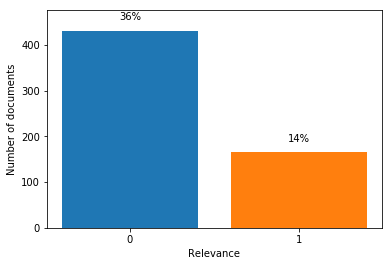

In [12]:
fig, ax = plt.subplots()
n = seen_df.shape[0]
y = df['relevant']
for i, (name, group) in enumerate(seen_df.groupby('relevant')):
    ax.bar(i, group.shape[0])
    ax.text(i, group.shape[0]+n*0.02, f'{group.shape[0]/n:.0%}',ha="center")

ax.set_xticks([0,1])
ax.set_ylim(ymax=ax.get_ylim()[1]*1.05)
ax.set_xlabel('Relevance')
ax.set_ylabel('Number of documents')

IndexError: list index out of range

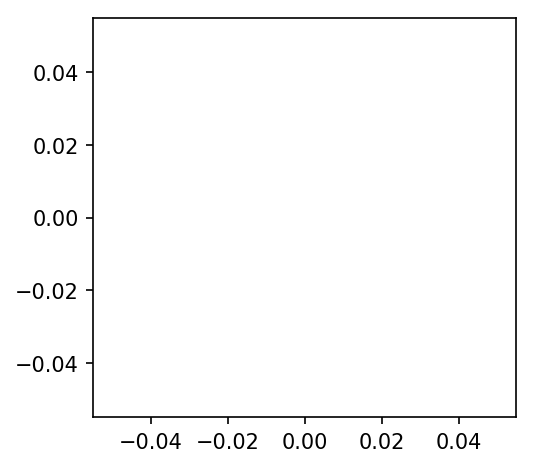

In [13]:
fig = plt.figure(figsize=(8,12),dpi=150)
for i, (n, v) in enumerate(cat_dict.items()):
    v = df.columns.intersection(v)
    ax = fig.add_subplot(3,2,i+1)
    pdf = df.loc[df['relevant']==1,v] 
    pdf['any'] = pdf.sum(axis=1)
    ndocs = pdf['any'].astype("bool").sum()
    pdf = pdf[v].melt()
    
    pdf.groupby('variable').sum().plot.bar(ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha="right")
    ax.set_title(f"{n} - {ndocs} docs")
    
fig.tight_layout()

In [12]:
noar6 = df[(df['seen']==1) & (df['ar5']==0) & df['relevant']==1]
print(len(noar6.index))
noar6 = noar6[noar6[df.columns.intersection(cat_dict['AR6 Impact'])].sum(axis=1)==0]
noar6.shape

167


(29, 93)

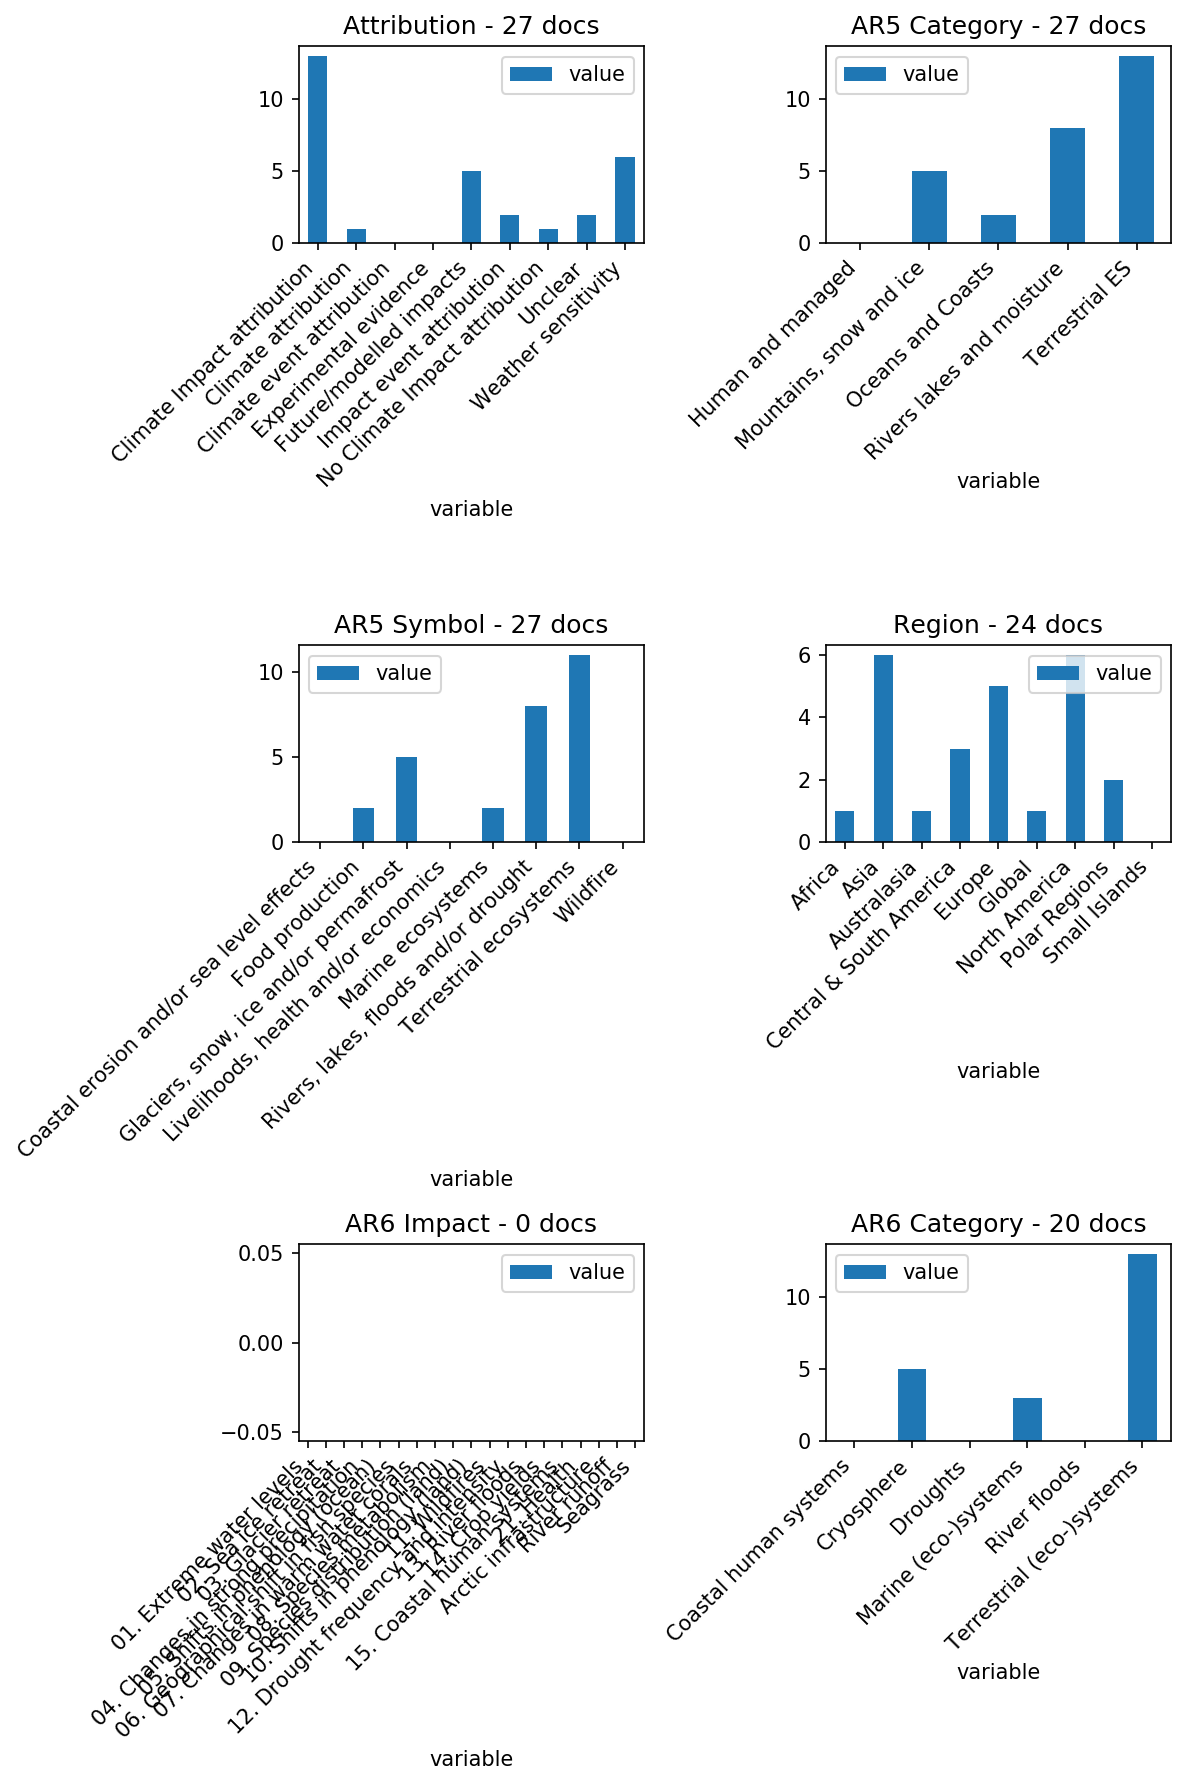

In [17]:
fig = plt.figure(figsize=(8,12),dpi=150)
for i, (n, v) in enumerate(cat_dict.items()):
    v = df.columns.intersection(v)
    ax = fig.add_subplot(3,2,i+1)
    pdf = noar6.loc[df['relevant']==1,v] 
    pdf['any'] = pdf.sum(axis=1)
    ndocs = pdf['any'].astype("bool").sum()
    pdf = pdf[v].melt()
    
    pdf.groupby('variable').sum().plot.bar(ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha="right")
    ax.set_title(f"{n} - {ndocs} docs")
    
fig.tight_layout()

## Vectorize

In [13]:
revectorize = False
if revectorize:
    vec = TfidfVectorizer(
        ngram_range=(1,1),
        min_df=20, max_df=0.8, strip_accents='unicode', 
        max_features=20000,
        tokenizer=snowball_stemmer()
    )

    X = vec.fit_transform(df['content'].astype("str"))   
    with open ('../data/vec.pickle','wb') as f:
        pickle.dump(vec, f)
    import scipy.sparse
    scipy.sparse.save_npz('../data/X.npz', X)
else:
    with open ('../data/vec.pickle','rb') as f:
        vec = pickle.load(f)
        X = scipy.sparse.load_npz('../data/X.npz')

In [19]:
from sklearn.model_selection import KFold

y = df['relevant']
now = datetime.datetime.now()
clf_models = [
    {
        'title': 'SVM', 
        'model': SVC(kernel='linear',class_weight='balanced',probability=True)
    },
    {
        'title':"Neural Net",
        'model': MLPClassifier(
            solver='lbfgs', 
            alpha=0.1,
            hidden_layer_sizes=(10), 
            random_state=1
        )
    },
    {
        'title': 'Naive Bayes', 
        'model': MultinomialNB(alpha=0.1)     
    }
]

clf_models = cross_validate_models(X, y, clf_models, seen_index)

1
2
3
4
5
6
7
8
9
10


In [ ]:
fig, axs = plt.subplots(1, len(clf_models),dpi=125,figsize=(8,5),sharey=True)              
plot_model_output(clf_models,  ['p','r','e'], fig, axs)
for ax in axs:
    ax.set_xticklabels(["precision","recall","accuracy"])
fig.tight_layout()
plt.savefig(f'../plots/prediction_models/relevance_prediction_{now.strftime("%Y-%m-%d_%H:%M:%S")}.pdf',bbox_inches="tight")
plt.show()

In [ ]:
from sklearn.model_selection import KFold

y = df['relevant']
now = datetime.datetime.now()
clf_models = [
    {
        'title': 'SVM', 
        'model': SVC(kernel='linear',class_weight='balanced',probability=True)
    },
    {
        'title':"Neural Net",
        'model': MLPClassifier(
            solver='lbfgs', 
            alpha=0.1,
            hidden_layer_sizes=(10), 
            random_state=1
        )
    },
    {
        'title': 'Naive Bayes', 
        'model': MultinomialNB(alpha=0.1)     
    }
]

clf_models_random = cross_validate_models(X, y, clf_models, r_index)

In [ ]:
fig, axs = plt.subplots(1, len(clf_models),dpi=125,figsize=(8,5),sharey=True)              
plot_model_output(clf_models,  ['p','r','e'], fig, axs)
fig.tight_layout()
plt.savefig(f'../plots/prediction_models/relevance_prediction_random_{now}.pdf',bbox_inches="tight")
plt.show()

In [14]:
clf = SVC(kernel='linear',class_weight='balanced',probability=True)
clf.fit(X[r_index],y[r_index])
y_pred = clf.predict_proba(X[unseen_index])

In [15]:
df['prediction'] = None
df.loc[unseen_index,'prediction'] = y_pred[:,1]

19761
316475


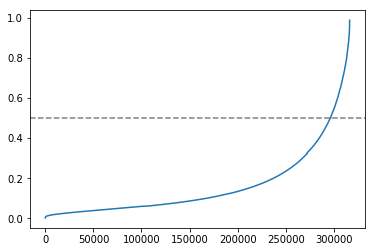

In [16]:
plt.close()

fig, ax = plt.subplots()

pdf = df.sort_values('prediction').reset_index(drop=True)
ax.plot(pdf.index,pdf['prediction'])
ax.axhline(0.5,linestyle="--",color="grey")

print(pdf[pdf['prediction']>0.5].shape[0])
print(pdf[pdf['prediction'].notna()].shape[0])

p_rel_index = df[df['prediction']>0.5].index

plt.show()

In [18]:
tagged_docs = set(Doc.objects.filter(tag__query=q).values_list('pk',flat=True))
len(tagged_docs)

770

In [19]:
django.db.connection.close()
import datetime
now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M")

tag = Tag(
    title="predicted relevant sample {}".format(now),
    query=q
)
tag.save()

max_docs = 20
docs_added = 0
prel = True
for i, row in df.query('prediction>0.5').sample(frac=1).reset_index(drop=True).iterrows():
    if row['id'] in tagged_docs:
        continue
    d = Doc.objects.get(id=row['id'])
    if docs_added < max_docs:
        d.tag.add(tag)
        docs_added+=1
    else:
        break  
    if row['prediction'] < 0.5 and prel:
        print(docs_added)
        prel = False

    
tag.update_tag()

In [37]:
import datetime
now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M")

tag = Tag(
    title="predicted relevant sample {}".format(now),
    query=q
)
tag.save()

max_docs = 250
docs_added = 0
prel = True
for i, row in df.sort_values('prediction',ascending=False).head(3500).reset_index(drop=True).iterrows():
    d = Doc.objects.get(id=row['id'])
    if d.docownership_set.filter(query=q).exists():
        continue
    else:
        if docs_added < max_docs:
            d.tag.add(tag)
            docs_added+=1
        else:
            break  
        if row['prediction'] < 0.5 and prel:
            print(docs_added)
            prel = False

    
tag.update_tag()

In [40]:
model_df = pd.DataFrame(clf_models)
model_df.to_csv(f"../data/doctables/models_rel_{now}.csv",index=False)
df[['id','prediction']].to_csv(f'../data/doctables/predictions_rel_{now}.csv',index=False)

In [41]:
y = df['Terrestrial ecosystems']

clf_models = [
    {
        'title': 'SVM', 
        'model': SVC(kernel='linear',class_weight='balanced',probability=True)
    },
    {
        'title':"Neural Net",
        'model': MLPClassifier(
            solver='lbfgs', 
            alpha=0.1,
            hidden_layer_sizes=(10), 
            random_state=1
        )
    },
    {
        'title': 'Naive Bayes', 
        'model': MultinomialNB(alpha=0.1)     
    }
]

ecosystem_models = cross_validate_models(X, y, clf_models, new_index)

/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


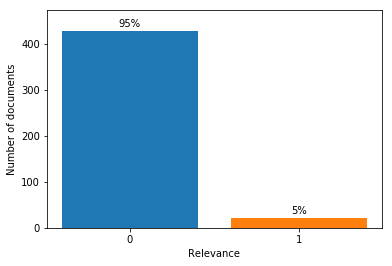

In [42]:
fig, ax = plt.subplots()

pdf = df[df.index.isin(new_index)]
n = pdf.shape[0]

for i, (name, group) in enumerate(pdf.groupby('Terrestrial ecosystems')):
    ax.bar(i, group.shape[0])
    ax.text(i, group.shape[0]+n*0.02, f'{group.shape[0]/n:.0%}',ha="center")

ax.set_xticks([0,1])
ax.set_ylim(ymax=ax.get_ylim()[1]*1.05)
ax.set_xlabel('Relevance')
ax.set_ylabel('Number of documents')

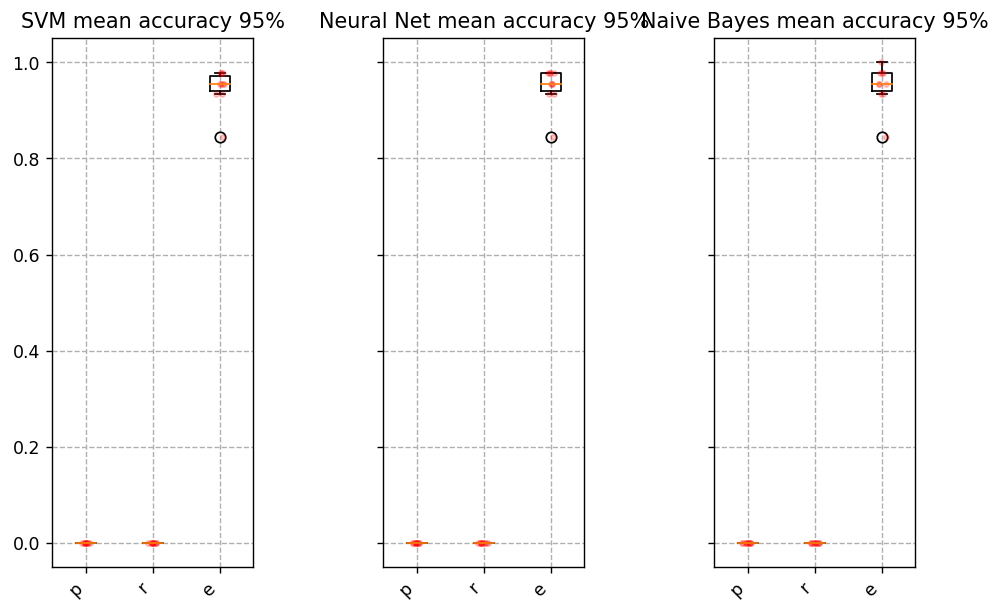

In [102]:
fig, axs = plt.subplots(1, len(ecosystem_models),dpi=125,figsize=(8,5),sharey=True)              
plot_model_output(ecosystem_models, ['p','r','e'], fig, axs)
plt.show()

In [44]:
model_df = pd.DataFrame(ecosystem_models)
model_df.to_csv(f"../data/doctables/models_ecosystem_{now}.csv",index=False)

In [30]:
p_rel_index

Int64Index([     7,     16,     37,    119,    139,    148,    158,    180,
               199,    220,
            ...
            317576, 317591, 317610, 317612, 317625, 317629, 317631, 317634,
            317652, 317686],
           dtype='int64', length=20845)

In [20]:
from sklearn.model_selection import KFold

classes = cat_dict['AR5 Category']
y = np.matrix(df[classes])
print(y.shape)

clf = OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced", probability=True))
clf.fit(X[r_index],y[r_index])
y_pred = clf.predict_proba(X[p_rel_index])

(317689, 5)


In [57]:
django.db.connection.close()

missings = p_rel_index
import datetime
now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M")
for i, c in enumerate(cat_dict['AR5 Category']):
    print(c)
    cdf = df.loc[p_rel_index[np.argwhere(y_pred[:,i]>0.4)[:,0]]]
    for j, r in cdf.head().iterrows():
        print(r['title'])
    print(cdf.shape)
    


    tag = Tag(
        title=f"predicted {c} sample {now}",
        query=q
    )
    tag.save()

    max_docs = 20
    docs_added = 0
    prel = True
    for i, row in cdf.sample(frac=1).reset_index(drop=True).iterrows():
        d = Doc.objects.get(id=row['id'])
        if d.docownership_set.filter(query=q).exists():
            continue
        else:
            if docs_added < max_docs:
                d.tag.add(tag)
                docs_added+=1
            else:
                break  
            if row['prediction'] < 0.5 and prel:
                print(docs_added)
                prel = False


    tag.update_tag()

Terrestrial ES
Chronic water stress reduces tree growth and the carbon sink of deciduous hardwood forests
Geospatial Modeling for Investigating Spatial Pattern and Change Trend of Temperature and Rainfall
Multidecadal trends in area burned with high severity in the Selway-Bitterroot Wilderness Area 1880-2012
The capacity to cope with climate warming declines from temperate to tropical latitudes in two widely distributed Eucalyptus species
Establishment of Nothofagus pumilio at upper treelines across a precipitation gradient in the northern Patagonian Andes
(3885, 94)
Mountains, snow and ice
The multi-millennial Antarctic commitment to future sea-level rise
Mean relative sea level rise along the coasts of the China Seas from mid-20th to 21st centuries
Recent Antarctic sea ice trends in the context of Southern Ocean surface climate variations since 1950
Accelerated Antarctic ice loss from satellite gravity measurements
Tipping Points in the Arctic: Eyeballing or Statistical Significance?

In [58]:
cdf = df.loc[p_rel_index[np.argwhere(y_pred.max(axis=1)<0.5)[:,0]]]
for j, r in cdf.head().iterrows():
    print(r['title'])
print(cdf.shape)

Time series analysis of the long-term hydrologic impacts of afforestation in the Agueda watershed of north-central Portugal
Ice Core Records of West Greenland Melt and Climate Forcing
Molecular mechanisms of combined heat and drought stress resilience in cereals
Effect of global warming on soil respiration and cumulative carbon release in biocrust-dominated areas in the Tengger Desert, northern China
Multidecadal trends in area burned with high severity in the Selway-Bitterroot Wilderness Area 1880-2012
(15077, 94)


In [59]:
tag = Tag(
    title=f"predicted climate system sample {now}",
    query=q
)
tag.save()

max_docs = 20
docs_added = 0
prel = True
for i, row in cdf.sample(frac=1).reset_index(drop=True).iterrows():
    d = Doc.objects.get(id=row['id'])
    if d.docownership_set.filter(query=q).exists():
        continue
    else:
        if docs_added < max_docs:
            d.tag.add(tag)
            docs_added+=1
        else:
            break  
        if row['prediction'] < 0.5 and prel:
            print(docs_added)
            prel = False


tag.update_tag()

In [ ]:
from sklearn.model_selection import KFold

classes = cat_dict['AR5 Category']
y = np.matrix(df[classes])
print(y.shape)

multimodels = [
    {
        'title': 'One vs rest SVC', 
        'model': OneVsRestClassifier(SVC(kernel='linear', probability=True))
    },
    {
        'title': 'One vs rest SVC balanced', 
        'model': OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced", probability=True))
    },
]

multimodels_ar5, metrics = cross_validate_models(X, y, multimodels, seen_index, classes=classes)


In [ ]:
fig, axs = plt.subplots(1, len(multimodels_ar5),dpi=125,figsize=(8,5),sharey=True)              
plot_model_output(multimodels_ar5, m_metrics, fig, axs)
plt.show()

In [ ]:
fig, axs = plt.subplots(1, len(multimodels_ar5),dpi=125,figsize=(8,5),sharey=True)              
plot_model_output(multimodels_ar5_symbol, metrics, fig, axs)
plt.show()

In [ ]:
model_df = pd.DataFrame(multimodels_ar5)
model_df.to_csv(f"../data/doctables/models_multi_ar5_{now}.csv",index=False)

In [ ]:
clf = OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced", probability=True))
clf.fit(X[seen_index],y[seen_index])
y_pred = clf.predict_proba(X[unseen_index])


In [88]:
from sklearn.model_selection import KFold

classes = cat_dict['AR5 Symbol']
y = np.matrix(df[classes])
print(y.shape)

multimodels = [
    {
        'title': 'One vs rest SVC', 
        'model': OneVsRestClassifier(SVC(kernel='linear', probability=True))
    },
    {
        'title': 'One vs rest SVC balanced', 
        'model': OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced", probability=True))
    },
]

multimodels_ar5_symbol, metrics = cross_validate_models(X, y, multimodels, new_index, classes=classes)

(317383, 8)
1


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


2


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


3


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


4


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


5


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


6


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6 is present in all training examples.
  str(classes[c]))
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6 is present in all training examples.
  str(classes[c]))
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 d

7


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


8


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


9


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


10


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


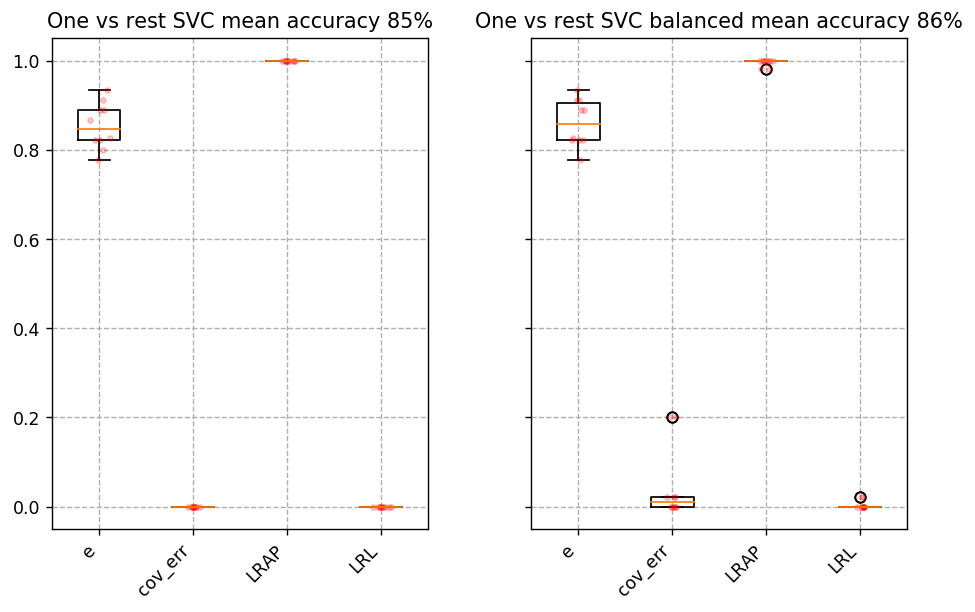

In [94]:
fig, axs = plt.subplots(1, len(multimodels_ar5_symbol),dpi=125,figsize=(8,5),sharey=True)              
plot_model_output(multimodels_ar5_symbol, m_metrics, fig, axs)
plt.show()

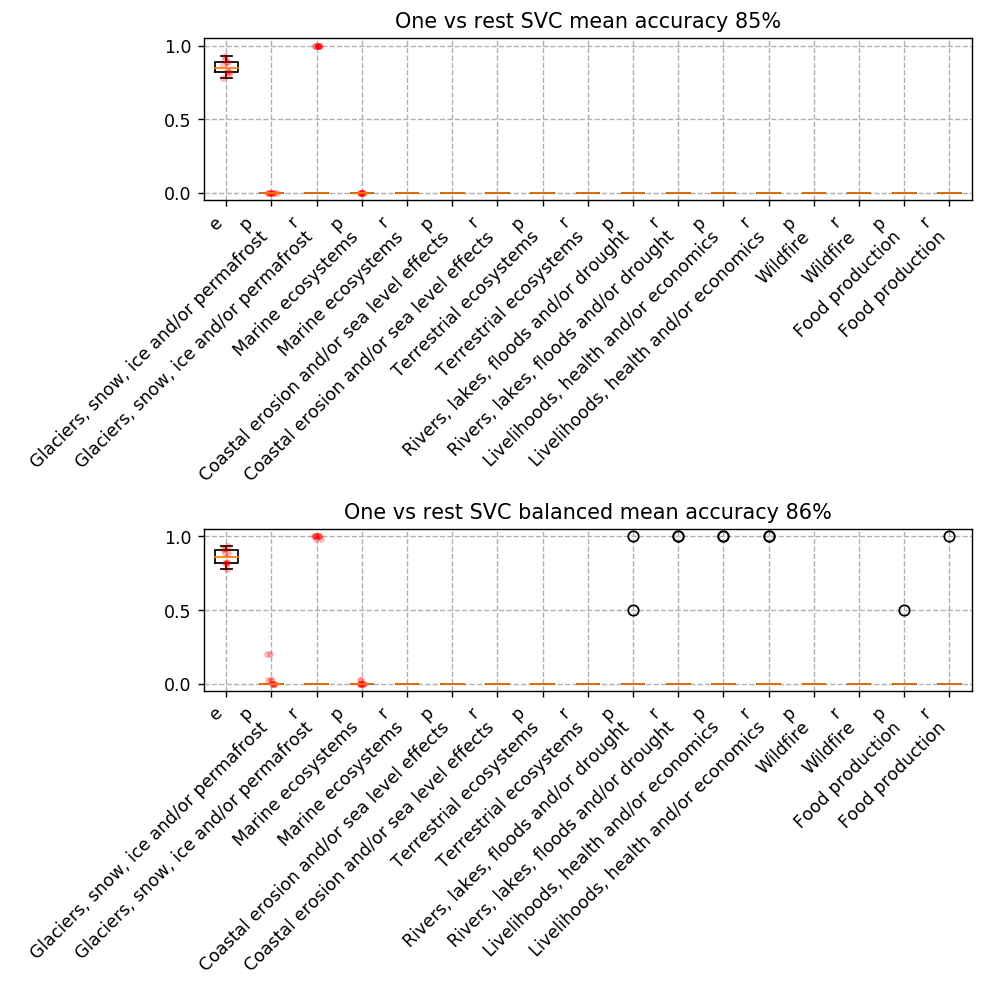

In [98]:
fig, axs = plt.subplots(len(multimodels_ar5_symbol),dpi=125,figsize=(8,8),sharey=True)
plot_model_output(multimodels_ar5_symbol, metrics, fig, axs)
plt.show()

In [91]:
model_df = pd.DataFrame(multimodels_ar5_symbol)
model_df.to_csv(f"../data/doctables/models_multi_ar5_symbol_{now}.csv",index=False)